<a href="https://colab.research.google.com/github/FerRojas00/Proyecto_Integrador/blob/main/Avance5_Equipo_26_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**
## Proyecto Integrador (Gpo 26)
> ### Tecnológico de Monterrey
>### Avance 5 - **Modelo Final**


## -

## **Automatización del Registro de Materiales Médicos mediante Visión Computacional**

### *EQUIPO* 26


* ### Luis Fernando Rojas Marta - A00757351
* ### Jose Eduardo Carreon - A01372413


### **Carga e Instalacion de Librerias y Modelos:**
Ejecutar una sola vez

In [ ]:
# Instalacion de Librerias de YOLO y EasyOCR
!pip install ultralytics
!pip install easyocr

In [2]:
# Montaje de la Unidad de Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Importacion de las Librerias
from ultralytics import YOLO
import cv2
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
from PIL import Image
import easyocr
from datetime import datetime

## **Funciones**

In [26]:
####################
'''
FUNCIONES y MODELO:
'''
####################

#### Carga del modelo
#model = YOLO("/content/drive/MyDrive/YOLOv8_resultados50EPOCH/train/weights/best.pt")                                # Direccion Eduardo
model = YOLO("/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/YOLOv8_resultados50EPOCH/train/weights/best.pt") # Direccion Fer


#### ##### RUTINA PRINCIPAL ######
def procesar_imagen_con_etiquetas(ruta_imagen, etiquetas=["REF", "LOT", "FABRICACION", "CADUCIDAD"]):

    #IMAGEN:Cargar la imagen
    image = cv2.imread(ruta_imagen)

    #YOLO: Inferencia de etiquetas con YOLO
    results = model(image)[0]
    boxes = results.boxes.xyxy.cpu().numpy()  #SE guardan las coordenadas (x1, y1, x2, y2)
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cropped = image[y1:y2, x1:x2]
        cropped_images.append(cropped)

    #OCR: Uso de EasyOCR sobre las regiones detectadas
    reader = easyocr.Reader(['en'])  # Agrega 'es' si hay texto en español
    textos_ocr = []
    for i, crop in enumerate(cropped_images):
        ocr_result = reader.readtext(crop)
        for detection in ocr_result:
            textos_ocr.append(detection[1])

    #DATAFRAME: Creacion de un Dataframe para analisis
    results_df = pd.DataFrame(textos_ocr, columns=["Text"])

    #FECHAS: Extraer fechas si es solicitado
    incluir_fab = "FABRICACION" in etiquetas
    incluir_cad = "CADUCIDAD" in etiquetas
    if incluir_fab or incluir_cad:
        fab_fecha, cad_fecha = extraer_fechas(results_df)
    else:
        fab_fecha, cad_fecha = None, None

    #TAGS: Limpieza de la lista para solo dejar etiquetas OCR reales
    etiquetas_ocr = [et for et in etiquetas if et not in ["FABRICACION", "CADUCIDAD"]]
    valores_extraidos = extraer_valores_por_tag(results_df, etiquetas_ocr)

    #Agregar fechas si se solicitaron
    if incluir_fab:
        valores_extraidos["FABRICACION"] = fab_fecha
    if incluir_cad:
        valores_extraidos["CADUCIDAD"] = cad_fecha

    return valores_extraidos, cropped_images


###### Funcion para extraer fechas en formato AAAA-MM-DD
def extraer_fechas(results_df):
    #Uso de Regex para el formato de fecha
    fecha_patron = r"\b\d{4}-\d{2}-\d{2}\b"
    fechas = []

    for idx, texto in results_df["Text"].items():
        if pd.isna(texto):
            continue

        #Buscar fechas en el texto
        fechas_encontradas = re.findall(fecha_patron, texto)
        fechas.extend(fechas_encontradas)

    #Eliminar duplicados y ordenar por fecha
    fechas = sorted(list(set(fechas)))

    #Determinar FAB y CAD
    fab_fecha = fechas[0] if len(fechas) > 0 else "NA"
    cad_fecha = fechas[1] if len(fechas) > 1 else "NA"

    return fab_fecha, cad_fecha



###### Funcion para buscar valores por etiquetas
def extraer_valores_por_tag(results_df, tags):
    valores = {tag: "NA" for tag in tags}

    for tag in tags:
        for idx, texto in results_df["Text"].items():
            if pd.isna(texto):
                continue

            #Se limpia el texto para comparacion
            clean_texto = texto.upper().replace("[", "").replace("]", "")

            #Caso 1: Si es exactamente igual (etiqueta sola), tomamos siguiente entrada
            if clean_texto.strip() == tag:
                if idx + 1 in results_df.index:
                    valores[tag] = results_df.loc[idx + 1, "Text"]
                break

            #Caso 2:Si la etiqueta viene combinada con el valor
            elif tag in clean_texto:
                match = re.search(rf"{tag}\s*[:\-]?\s*([A-Z0-9]+)", clean_texto)
                if match:
                    valores[tag] = match.group(1)
                    break
                partes = clean_texto.split()
                if len(partes) > 1 and tag in partes[0]:
                    valores[tag] = partes[1]
                    break

    return valores


####### Consrtuccion de fila en el Dataframe
def construir_fila_dataframe(ruta_imagen, valores_dict):
    fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    base_fila = {
        "imagen": os.path.basename(ruta_imagen),
        "fecha_procesado": fecha_actual,
        "REF": valores_dict.get("REF", "NA"),
        "LOT": valores_dict.get("LOT", "NA"),
        "FABRICACION": valores_dict.get("FABRICACION", "NA"),
        "CADUCIDAD": valores_dict.get("CADUCIDAD", "NA")
    }

    #Agregar si hay etiquetas adicionales
    etiquetas_extra = [k for k in valores_dict if k not in base_fila]
    for extra in etiquetas_extra:
        base_fila[extra] = valores_dict[extra]

    return pd.DataFrame([base_fila])

#Guardado en un CSV ===
def guardar_en_csv(df_fila, nombre_csv="/content/drive/MyDrive/08_Proyecto_Integrador/Libretas/datos_etiquetas.csv"):
    if os.path.exists(nombre_csv):
        df_fila.to_csv(nombre_csv, mode='a', header=False, index=False)
    else:
        df_fila.to_csv(nombre_csv, mode='w', header=True, index=False)

## **Integracion**


1.   Rutina para busqueda de Etiquetas y obtencion de Tags
2.   Creacion de un Dataframe
3.   Guardado de valores en un CSV



In [20]:
#RUTA: de la Imagen a procesar:
ruta = "/content/drive/MyDrive/08_Proyecto_Integrador/Label_Photos/Label_59.jpg"
#TAGS: Etiquetas que buscar:
etiquetas = ["REF", "LOT", "CADUCIDAD", "FABRICACION", "CANTIDAD"]


#PASO 1: Procesar la imagen
valores, crops = procesar_imagen_con_etiquetas(ruta, etiquetas)

#IMPRESION: Mostrado de resultados
print("Resultados de la Imagen:")
for etiqueta, valor in valores.items():
  print(f"{etiqueta}: {valor}")

#PASO 2: Crear la fila del DataFrame
fila = construir_fila_dataframe(ruta, valores)

#PASO 3: Guardar en el CSV
guardar_en_csv(fila)


0: 640x480 2 etiquetas, 10.3ms
Speed: 3.8ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)
Resultados de la Imagen:
REF: (240)11776223190
LOT: (10)82396601
CANTIDAD: NA
FABRICACION: 2024-09-03
CADUCIDAD: 2026-02-28


In [28]:
#Dataframe:
fila

,imagen,fecha_procesado,REF,LOT,FABRICACION,CADUCIDAD,CANTIDAD
0,Label_59.jpg,2025-05-31 05:33:18,(240)11776223190,(10)82396601,2024-09-03,2026-02-28,NA


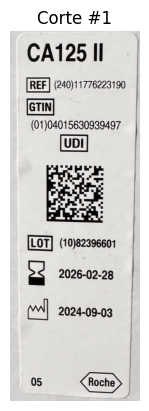

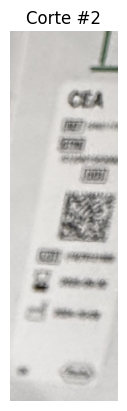

In [23]:

# Mostrar visualmente cada recorte detectado
for i, crop in enumerate(crops):
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Corte #{i+1}")
    plt.axis('off')
    plt.show()